# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

### ID: 011996279 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import random
import time 


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat        dog       bird        dog


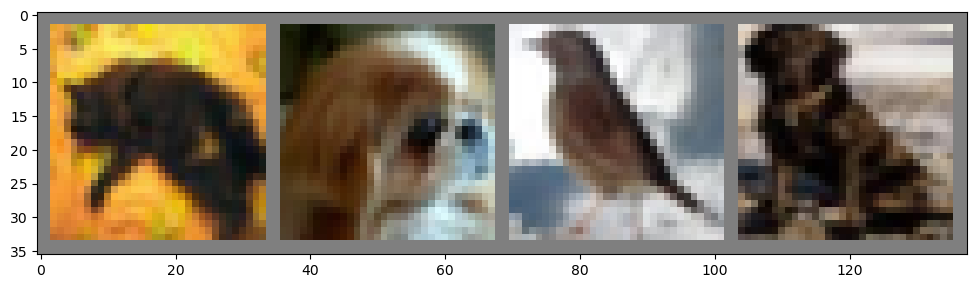

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
# CNN Hyperparamaters:
num_epochs = 8
lr = 0.001

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)#, padding='valid')
        self.conv2 = nn.Conv2d(self.conv1.out_channels, out_channels=96, kernel_size=3)#, padding='valid')
        self.conv3 = nn.Conv2d(self.conv2.out_channels, out_channels=288, kernel_size=3)#, padding='valid')
        self.fc_layer1 = nn.Linear(self.conv3.out_channels * 4, out_features=40)
        self.fc_layer2 = nn.Linear(self.fc_layer1.out_features, len(classes))
        self.maxpool = nn.MaxPool2d(2,2)
        #self.ReLU = F.relu(inplace=True)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc_layer1.in_features)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        return x
    
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [8]:
%%time
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
for epoch in range(1, (num_epochs + 1)):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # list of [(input, label)] tuples 

        optimizer.zero_grad() # zero & re-zero the param grads 
        outputs = net.forward(inputs) #forward 
        loss = criterion(outputs, labels)
        loss.backward() # start the backprop 
        optimizer.step() 
        

        # print as run epochs 
        running_loss += loss.item()
        if i % 300 == 299:    # print update at every 300 mini-batches
            print(f'[epoch, samples]: [{epoch}, {i + 1:3d}] epoch loss: {running_loss / 300:.2f}')
    print(f'\nepoch{epoch} ending loss: {running_loss / 300:.2f}')
        

print('Finished Training')
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

[epoch, samples]: [1, 300] epoch loss: 1.67
[epoch, samples]: [1, 600] epoch loss: 2.98

epoch1 ending loss: 3.72
[epoch, samples]: [2, 300] epoch loss: 1.06
[epoch, samples]: [2, 600] epoch loss: 2.06

epoch2 ending loss: 2.65
[epoch, samples]: [3, 300] epoch loss: 0.84
[epoch, samples]: [3, 600] epoch loss: 1.66

epoch3 ending loss: 2.16
[epoch, samples]: [4, 300] epoch loss: 0.70
[epoch, samples]: [4, 600] epoch loss: 1.41

epoch4 ending loss: 1.82
[epoch, samples]: [5, 300] epoch loss: 0.59
[epoch, samples]: [5, 600] epoch loss: 1.19

epoch5 ending loss: 1.56
[epoch, samples]: [6, 300] epoch loss: 0.50
[epoch, samples]: [6, 600] epoch loss: 1.01

epoch6 ending loss: 1.33
[epoch, samples]: [7, 300] epoch loss: 0.40
[epoch, samples]: [7, 600] epoch loss: 0.85

epoch7 ending loss: 1.12
[epoch, samples]: [8, 300] epoch loss: 0.32
[epoch, samples]: [8, 600] epoch loss: 0.67

epoch8 ending loss: 0.91
Finished Training
CPU times: user 23min 48s, sys: 8min 6s, total: 31min 54s
Wall time: 9

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [9]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
samples = 0
correct_count = 0

with torch.no_grad(): # not training here, so don't need the grads 
    for data in testloader:
        images, labels = data

        outputs = net.forward(images) # get outputs from network

        _, pred = torch.max(outputs.data, 1)
        samples += labels.size(0)
        correct_count += (labels == pred).sum()
        for index, label in enumerate(labels):
            confusion_matrix[label.item(), pred[index].item()] +=1

model_accuracy = 100 * (correct_count / samples)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 73.75%


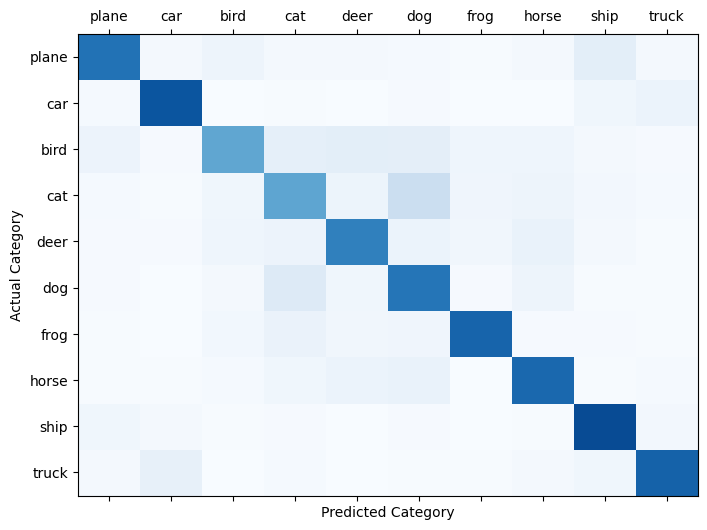

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** 

Experimented with various aspects of our CNN & optimization, including: 

- CNN Architecture: 
    - total network depth 
    - number of convolutional layers 
    - adding additional full-connected layers 
    - kernel size 4x4 vs 3x3
    - kernels/filters per convolutional layer 

#### Commentary on CNN Architecture: 
Adding the $2^{nd}$ fully-connected layer added significantly to runtime and did not meaningfully improve results. 
Changing the **total depth** of the network, and specifically the **number of convolutional layers** had similarly not meaningful-enough benefit to results to warrant the cost of higher runtime. We were able to make some gains by growing the number of kernels per layer, but were able to achieve a sufficient and acceptable accuracy without the highest values for numbers of kernels. Overall our accuracies didn't much change within the bounds of what we tried, and unfortunately the biggest variance came in runtime (CPU & wall), which was more affected by other computer-process limitations than by the values chosen for our hyperparameters and constructing and optimizing the CNN. 
  
- Optimization: 
    - Optimizer used - ADAM vs. SGD
    - Optimizer paramaters - ADAM - learning rate 
    - Optimizer paramaeters - SGD - learning rate and momentum 

#### Commentary on Optimization: 
There were certainly changes in trends within and across epochs for loss improvement but none of these metrics, within reasonable bounds discovered in papers, literature, google, etc significantly moved the needle on our accuracies and confusion matrix, in addition to the computer-process-specific CPU usage described above. 


##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *the accuracy overall was decent, but it's clear there was a range of accuracies for the 10 different classes with some being higher and others lower than the overall accuracy. Cross-entropy loss is designed to maximize the overall global accuracy across classes (and/or minimizing the loss), so the model is not really set up to optimize class-by-class accuracy. The accuracy measure itself is also prone to imbalances in data, in that you can have a model that only classifies a fruit as "orange" and happens to have a dataset with 80% oranges - it would show an 80% accuracy but would actually be a terrible classifier of fruit. Otherwise, the confusion matrix allows us to visually inspect how the model performed on classifying the various classes.*

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [11]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os


To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [12]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [13]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [14]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

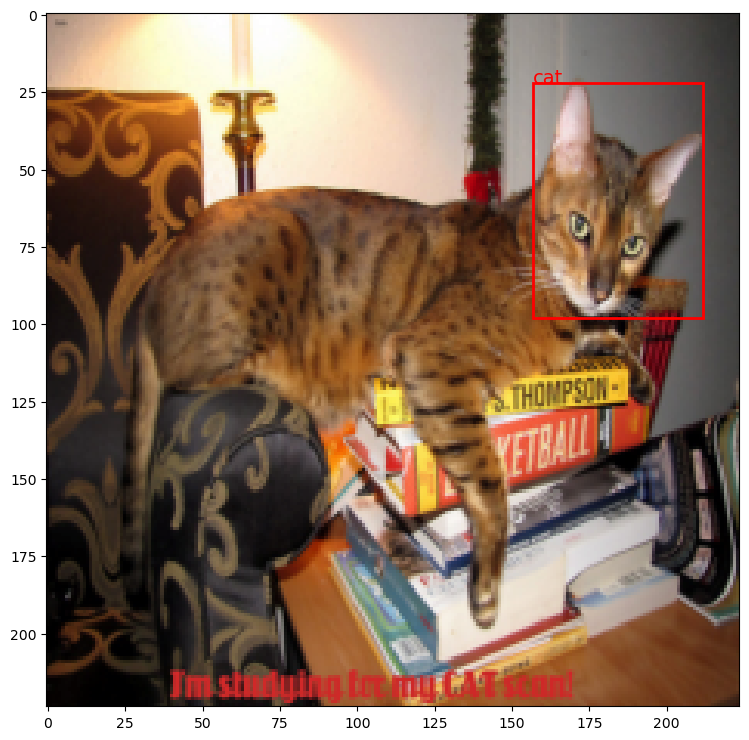

In [15]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        
        # no weight updates for Resnet layers: 
        for params in resnet18.parameters():
            params.required_grad = False 
        
        # convolutional layers 
        self.conv = nn.Sequential(*list(resnet18.children())[:-1])
        
        # fully connected layer for labels / classes 
        self.fc_label = nn.Sequential(
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes))
        
        # fully connected layer for bounding boxes 
        self.fc_bbox = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid())
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        x = self.conv(images)
        x = x.view(x.size(0), -1)
        label = self.fc_label(x)
        bbox = self.fc_bbox(x)
        return label, bbox 
        
#         #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [30]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    train_hist = defaultdict(list)
    validation_hist = defaultdict(list)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                
                
                images = sample['image'].to(device)
                bboxes = sample['bbox'].to(device)
                labels = sample['label'].to(device)

                optimizer.zero_grad()
                
                labels_out, bbox_pred = model(images)
                labels_loss = criterion_cls(labels_out, labels)
                bbox_loss = criterion_bbox(bbox_pred, bboxes, reduction='mean')

                running_loss += labels_loss.item() + bbox_loss.item()
                labels_pred = torch.max(labels_out, dim=1)[1]
                running_corrects += (labels_pred == labels).sum()

                if model.training:
                    loss = labels_loss + bbox_loss
                    loss.backward()
                    optimizer.step()
                    
                # update IOU     
                from dataloader import bb_intersection_over_union    
                for i in range(len(images)):
                    iou += bb_intersection_over_union(bboxes[i], bbox_pred[i])
                
                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # save some data for visualizing training & validation data runs for model 
            per_epoch_data = train_hist if model.training else validation_hist
            per_epoch_data['iou'].append(iou)
            per_epoch_data['epoch_loss'].append(epoch_loss)
            per_epoch_data['epoch_accuracy'].append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_hist, validation_hist

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [22]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = torchvision.ops.complete_box_iou_loss

# tried optimizing for each param of optimizers 
optimizer = optim.SGD(cnn.parameters(), lr=0.003, momentum=0.5) 
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
best_model, train_hist, validation_hist = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------


Once you are pleased with your results, see how your model can predict and localize cats and dogs!

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,14))
for i, j in enumerate(train_hist.keys()):
    ax[i].plot(range(10), train_hist[j], label='Training')
    ax[i].plot(range(10), validation_hist[j], label='Validation')
    ax[i].set_title(f'{j} as function of epochs')
    ax[i].legend()